# **Optical Conveyor Belt Transport Calculations for SrF molecules**

For Gen II SrF experiment, we will study cavity QED with molecules (e.g. cavity cooling and entanglement) in a science chamber that is separate from the MOT chamber.<br/>

We originally planned to use the Cornish group approach - 2 static Gaussian beams with fixed foci locations, offset in frequency using an AOM. This creates a traveling wave moving optical lattice. However, it mainly works for Rb and Cs because of their high polarizabilities and low initial temperatures. When applied to SrF, we found we need inordinate amounts of power to achieve a trap depth of 400 $\mu\,\text{K}$.

**Optical transport of SrF molecules from MOT to science chamber using 2 static Gaussian beams offset in frequency using an AOM.**

**Here, only use scalar polarizability of SrF. Neglect the small contribution from vector and tensor Stark shift.**<br/>
In fact, absolute ground state N=0, J=1/2, F=0 has no vector or tensor Stark shift. But, **we will transport in N=1 rotational states.** 

**Lowest observed temperature for SrF molecules via $\Lambda$-cooling is $\sim 40\, \mu\text{K}$. Aim for minimum optical trap depth $\sim 400 \,\mu\text{K}$ during transport.**

We want to see if we can **use not-far-detuned trap light (e.g. $\lambda = 664-665\,\text{nm}$ or even closer)**. There is a trade-off between lower power requirement at low detuning, and higher scattering rate. **Let's see how close of detuning we can go before the trapping scheme breaks down.**


# Outline of this code:

1. Set the correct resonance wavelength for X-A transition.
2. Define scalar polarizability as function of detuning from resonance.
3. Use existing transport code to compute power needed to exceed threshold of $400 \,\mu\text{K}$ limiting trap depth throughout transport path. Assume no maglev.
4. Compute the associated scattering rate at that power and detuning and look for when it drops below the threshold set by maximal rotatonal Raman scattering.
5. Extract the lower bound on (P, $\Delta$) for which both conditions hold: exceed $400 \,\mu\text{K}$ limiting trap depth and scattering rate below $0.04\,\text{ms}^{-1}$.

# Properties of SrF X-A Transition

Resonant frequency taken to be $\nu_0 = 451.95765\,\text{THz}$, equivalent to wavelength $\lambda_0 = 663.3198\,\text{nm}$.<br/>
Scalar polarizability in N=0 and N=1 states of $X^2\Sigma$ at $\lambda = 1064\,\text{nm}$ is 240 a.u. (atomic units). <br/>
Vector contribution is 1-3 a.u. for non-F=0 states and tensor contribution is 10-20 a.u. for non-F=0 states in N=1.

So in general, we can ignore the vector and tensor contributions of polarizability to the AC Stark shift here, to simplify our calculation.

# Summary of Main Results

Power needs to exceed 15 W and detuning exceed 8.2 THz ($\lambda$ = 675.6 nm) for limiting trap depth to be at least $400\,\mu\text{K}$ and scattering rate below $0.04\,\text{ms}^{-1}$ throughout transport. 

# Import Relevant Packages and Constants

In [295]:
#import relevant Python packages, special functions, and constants
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import epsilon_0, mu_0, c, k, g, hbar, physical_constants
from scipy.special import ellipk, ellipe
from scipy.optimize import curve_fit

# Define polarizability as a function of detuning from resonance

Compute $\alpha_s, \alpha_v, \alpha_t$ as function of detuning from resonance. <br/>
We find that $\alpha_s$ is the dominant contribution, with $\sim 10\%$ correction from $\alpha_t$ and $\sim 1\%$ correction from $\alpha_v$. For rest of calculation, just use $\alpha_s$ for simplicity.

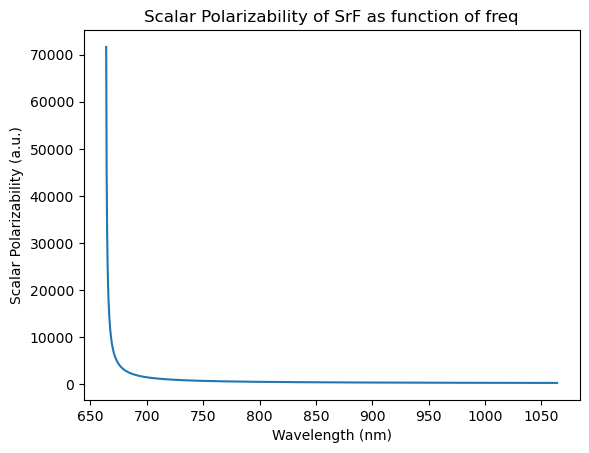

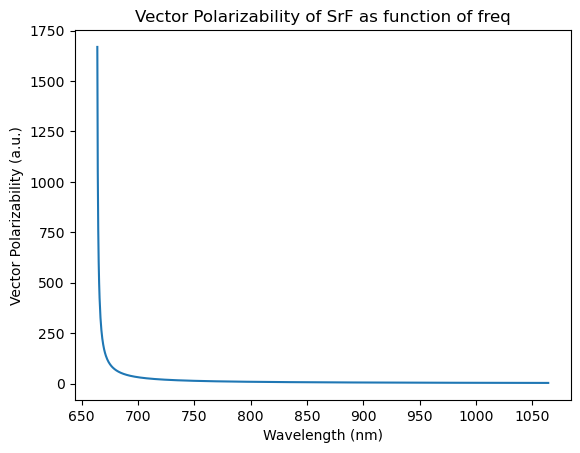

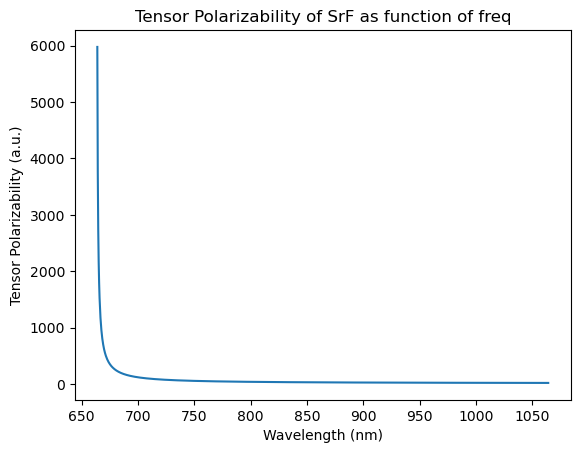

In [296]:
#our reference is the polarizability at 1064 nm calculated by Qian (see eq. 10 and Table 10 in "AC_Stark_Shift" writeup).
alpha_s_0 = 240.08 # in a.u.
alpha_v_0 = 3.49 #in a.u.
alpha_t_0 = 20.02 #in a.u.
resonance_freq = 451.95765e12 #in Hz
ODT_freq = 281.8e12 #in Hz

#here, freq is in units of THz
def alpha_s(lam):
    freq = c/lam
    return alpha_s_0*(1/(resonance_freq - freq) + 1/(resonance_freq + freq))/(1/(resonance_freq - ODT_freq) + 1/(resonance_freq + ODT_freq))

def alpha_v(lam):
    freq = c/lam
    return alpha_v_0*(1/(resonance_freq - freq) - 1/(resonance_freq + freq))/(1/(resonance_freq - ODT_freq) - 1/(resonance_freq + ODT_freq))

def alpha_t(lam):
    freq = c/lam
    return alpha_t_0*(1/(resonance_freq - freq) + 1/(resonance_freq + freq))/(1/(resonance_freq - ODT_freq) + 1/(resonance_freq + ODT_freq))

#plot how alpha_s scales for wavelength from 1064 nm to 664 nm
lam = np.linspace(664e-9, 1064e-9, 1000)
plt.plot(lam*1e9, alpha_s(lam))
plt.xlabel('Wavelength (nm)')
plt.ylabel('Scalar Polarizability (a.u.)')
plt.title('Scalar Polarizability of SrF as function of freq')
plt.show()

#plot how alpha_v scales for freq from 451.5 THz to 240 THz
plt.plot(lam*1e9, alpha_v(lam))
plt.xlabel('Wavelength (nm)')
plt.ylabel('Vector Polarizability (a.u.)')
plt.title('Vector Polarizability of SrF as function of freq')
plt.show()

#plot how alpha_t scales for freq from 451.5 THz to 240 THz
plt.plot(lam*1e9, alpha_t(lam))
plt.xlabel('Wavelength (nm)')
plt.ylabel('Tensor Polarizability (a.u.)')
plt.title('Tensor Polarizability of SrF as function of freq')
plt.show()

# Define parameters for transport geometry

In [297]:
#physical constants
bohr_rad = physical_constants['Bohr radius'][0] #Bohr radius in m
amu = physical_constants['atomic mass constant'][0] #atomic mass unit in kg

#transport geometry and example parameters
L = 40e-2 #length of conveyor belt in m. Assume for our chamber the transport distance is roughly 40 cm.
detuning = 0.19e12 #detuning of trap light in Hz (assume positive for red detuning)
resonance_freq = 451.95765e12 #in Hz
traplight_freq = resonance_freq - detuning #frequency of trap light in Hz
lam = c/traplight_freq #wavelength of trap light in m
P = 0.2 #trap light power in W

#SrF molecule parameters
m_SrF = 107 * amu #mass of SrF in kg. Sr-88 and F-19 isotopes.
gamma_SrF = 2*np.pi*6.6e6 #decay rate of SrF in Hz

#polarizability (only scalar) in real units
def alpha_SrF(lam):
    return alpha_s(lam) * 4*np.pi*epsilon_0 * bohr_rad**3

#waist size and focus position optimization parameters
w0min = 100e-6 #minimum waist to explore in parameter search
w0max = 250e-6#maximum waist to explore in parameter search
x0min = 0 #minimum focus position to explore in parameter search
x0max = L/2 #maximum focus position to explore in parameter, because the geometry is symmetric

#sample trap waist size and position
w0 = 180e-6 #optimum waist of light in m (no maglev)
x0 = 6.14e-2 #optimum focus position in m (no maglev)

#optimal parameter search params
num_grid_pts = 20 #number of grid points in heat map for calculating overall depth

# Define Functions for Gaussian Laser Beam

In [298]:
#define relevant functions for a Gaussian laser beam
#x is position along beam axis. w0 is beam waist. 
#x0 is focal point. lam is wavelength. P is power. 
#y and z are transverse coordinates.

def w(x,w0,x0,lam):
    xR = np.pi * w0**2 / lam
    return w0 * np.sqrt(1 + ((x-x0) / xR)**2)

def I0(P,x,w0,x0,lam):
    return 2 * P / (np.pi * w(x,w0,x0,lam)**2)

def gaussian_beam_intensity(x,x0,y,z,w0,lam,P):
    intensity = I0(P,x,w0,x0,lam) * np.exp(-2 * (y**2 + z**2) / w(x,w0,x0,lam)**2)
    return intensity

# Define Functions for Optical Conveyor Belt

Optical conveyor belt is formed by interfering counter-propagating Gaussian laser beams.<br/>
"No cosine" term is used when computing trap depth because by definition, trap depth is the "height" of the antinodes of the standing wave.

In [299]:
#define relevant functions for optical conveyor belt using interfering counter-propagating Gaussian beams
def conveyor_intensity(x,x0,y,z,w0,lam,P):
    k = 2 * np.pi / lam
    I1 = gaussian_beam_intensity(x,x0,y,z,w0,lam,P)
    I2 = gaussian_beam_intensity(x,L-x0,y,z,w0,lam,P)
    total = I1 + I2 + 2 * np.sqrt(I1 * I2) * np.cos(2*k*x)
    return total

#no cos is used for calculating trap depth which occurs at max intensity (antinodes)
def conveyor_intensity_no_cos(x,x0,y,z,w0,lam,P):
    I1 = gaussian_beam_intensity(x,x0,y,z,w0,lam,P)
    I2 = gaussian_beam_intensity(x,L-x0,y,z,w0,lam,P)
    total = I1 + I2 + 2 * np.sqrt(I1 * I2)
    return total

# Example of Optical Conveyor Belt Radial Intensity Profile Including Gravity

Gravity tilts the trapping potential because it's a linear mgz term.

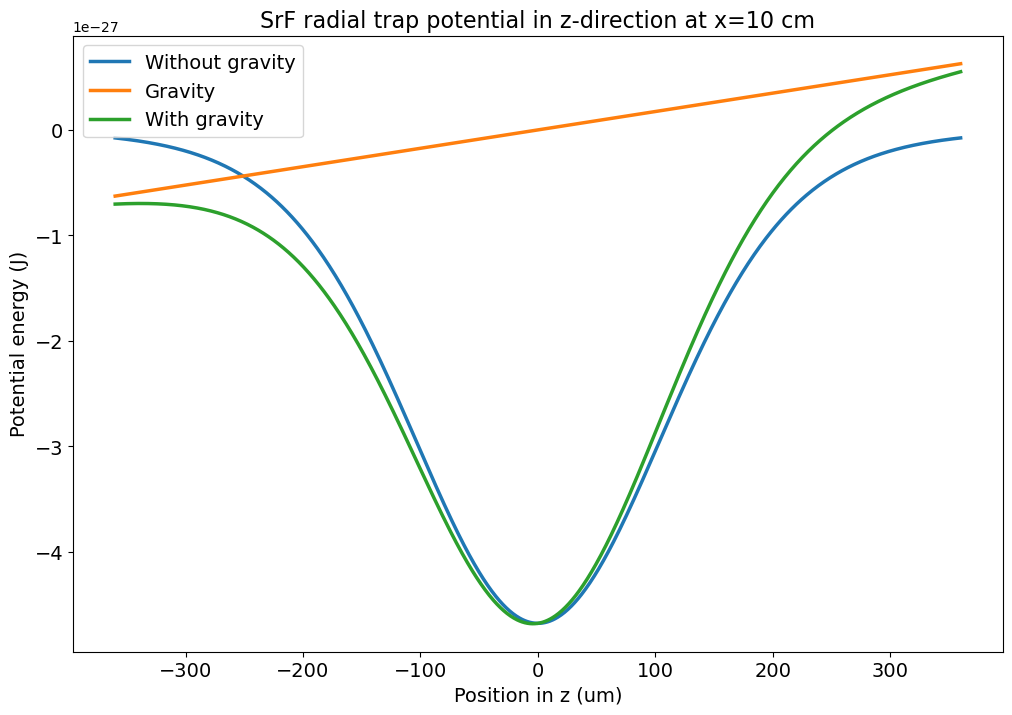

In [300]:
#plot radial depth including gravity (z-direction)

#first, let's plot an example of what the trapping potential looks like as a function of z, for some fixed axial position x along the belt
x = 10e-2 #10 cm along the belt
y = 0 

#potential well for SrF in the z-direction without gravity
def U_radial_SrF_without_grav(z,x,x0,w0,lam,P):
    return -alpha_SrF(lam)/(2*epsilon_0*c) * conveyor_intensity(x,x0,y,z,w0,lam,P)

#ignore cosine interference term
def U_radial_SrF_without_grav_no_cos(z,x,x0,w0,lam,P):
    return -alpha_SrF(lam)/(2*epsilon_0*c) * conveyor_intensity_no_cos(x,x0,y,z,w0,lam,P)

#potential well for SrF in z-direction including gravity
def U_radial_SrF_with_grav(z,x,x0,w0,lam,P):
    return U_radial_SrF_without_grav(z,x,x0,w0,lam,P) + m_SrF * g * z

def U_radial_SrF_with_grav_no_cos(z,x,x0,w0,lam,P):
    return U_radial_SrF_without_grav_no_cos(z,x,x0,w0,lam,P) + m_SrF * g * z

z = np.linspace(-2*w0,2*w0,1000)
plt.figure(figsize=(12, 8))
plt.plot(z*1e6,U_radial_SrF_without_grav(z,x,x0,w0,lam,P), label='Without gravity', linewidth=2.5)
plt.plot(z*1e6, m_SrF * g * z, label='Gravity', linewidth=2.5)
plt.plot(z*1e6,U_radial_SrF_with_grav(z,x,x0,w0,lam,P), label='With gravity', linewidth=2.5)
plt.xlabel('Position in z (um)', fontsize=14)
plt.ylabel('Potential energy (J)', fontsize=14)
plt.title(f'SrF radial trap potential in z-direction at x={100*x:.0f} cm', fontsize=16)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

#extract difference between local max for z > 0 and local min
depth = (np.max(U_radial_SrF_with_grav(z,x,x0,w0,lam,P)[z<0]) - np.min(U_radial_SrF_with_grav(z,x,x0,w0,lam,P)))/k*1e6

# SrF Optical Transport Calculations

## Axial (x), Non-Gravity Radial (y), and Gravity Radial (z) Trap Depths along Transport Axis (x)

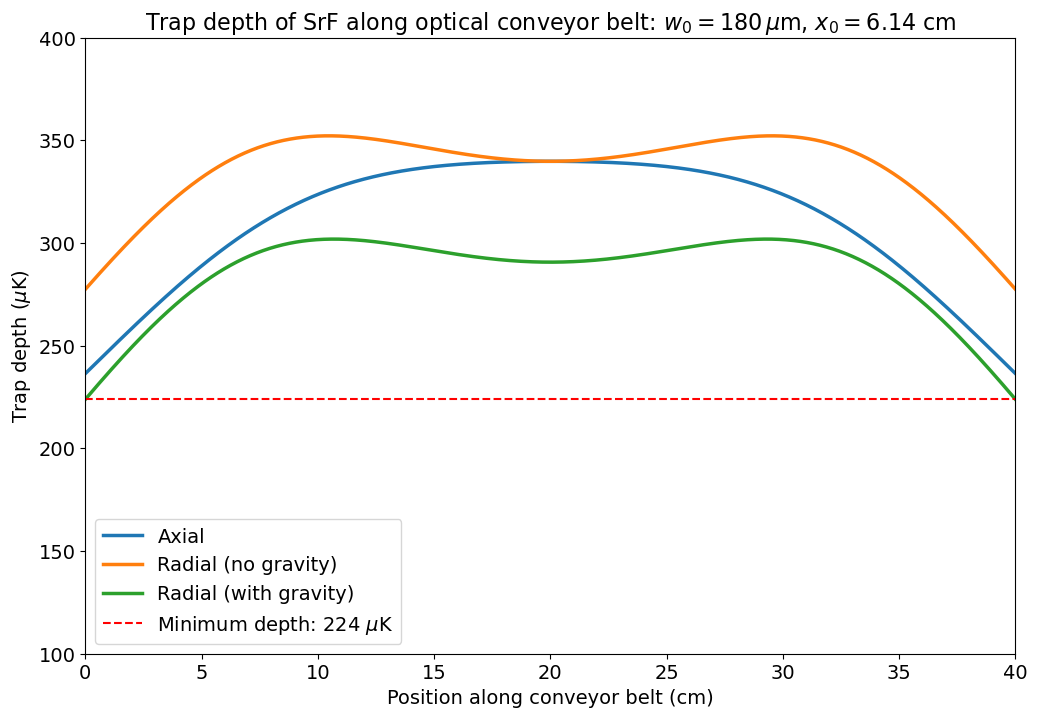

In [301]:
#now calculate the radial trap depth including gravity along the optical conveyor belt axis

x = np.linspace(0,L,1000)
y = 0
z = np.linspace(-2*w0,2*w0,1000)
depths = np.empty(len(x))

#no cos because we only consider trapping at the antinodes of the standing wave
for i in range(len(x)):
    depths[i] = (np.max(U_radial_SrF_with_grav_no_cos(z,x[i],x0,w0,lam,P)[z<0]) - np.min(U_radial_SrF_with_grav_no_cos(z,x[i],x0,w0,lam,P)))/k*1e6

#plot radial and axial trap depths

#in hindsight I could probably also do this with no cos since we only care about the antinodes?
def U_axial_potential_SrF(x,x0,y,z,w0,lam,P):
    return -(alpha_SrF(lam)/(2*epsilon_0*c))*conveyor_intensity(x,x0,y,z,w0,lam,P)

#axial trap depth of SrF in uK (x-direction)
def U_axial_SrF(x,x0,w0,lam,P):
    peak_intensity1 = I0(P,x,w0,x0,lam)
    peak_intensity2 = I0(P,x,w0,L-x0,lam)
    return (2*alpha_SrF(lam)*np.sqrt(peak_intensity1*peak_intensity2)/(epsilon_0*c)/k)*1e6

#radial trap depth of SrF in uK without gravity (y-direction)
def U_radial_SrF(x,x0,w0,lam,P):
    peak_intensity1 = I0(P,x,w0,x0,lam)
    peak_intensity2 = I0(P,x,w0,L-x0,lam)
    return (alpha_SrF(lam)/(2*epsilon_0*c)) * (peak_intensity1 + peak_intensity2 + 2*np.sqrt(peak_intensity1*peak_intensity2))/k*1e6

min_axial = np.min(U_axial_SrF(x,x0,w0,lam,P))
min_radial = np.min(U_radial_SrF(x,x0,w0,lam,P))
min_radial_grav = np.min(depths)
overall_min = min(min_axial, min_radial, min_radial_grav)

plt.figure(figsize=(12, 8))
plt.plot(x*1e2,U_axial_SrF(x,x0,w0,lam,P), label='Axial', linewidth=2.5)
plt.plot(x*1e2,U_radial_SrF(x,x0,w0,lam,P), label='Radial (no gravity)', linewidth=2.5)
plt.plot(x*1e2,depths, label='Radial (with gravity)', linewidth=2.5)
plt.axhline(y=overall_min, color='red', linestyle='--', label=f'Minimum depth: {round(overall_min)} $\mu$K')
plt.xlabel('Position along conveyor belt (cm)', fontsize=14)
plt.ylabel('Trap depth ($\mu$K)', fontsize=14)
plt.title(f'Trap depth of SrF along optical conveyor belt: $w_0 = {w0*1e6:.0f}\, \mu$m, $x_0 = {x0*1e2:.2f}$ cm', fontsize=16)
plt.ylim(100, 400)
plt.xlim(0, L*1e2)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

# Optimize for beam waist ($w_0$) and focus ($x_0$) positions for no magnetic levitation
## Compute limiting SrF trap depth (among axial and radial) along transport path.

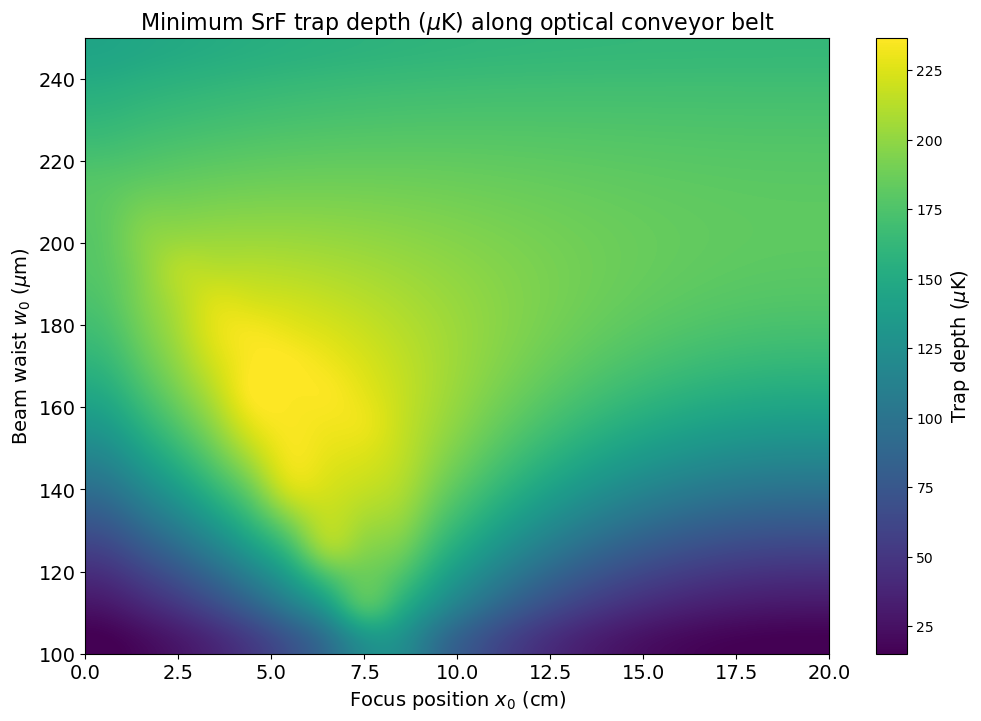

Optimum temperature: 237 µK
Optima coordinates: (w₀ = 163.2 µm, x₀ = 4.21 cm)


In [302]:
#for a range of beam waists and focus positions, compute the minimum trap depth (among radial and axial)
#along the optical conveyor belt path

x0s = np.linspace(x0min, x0max, num_grid_pts) #in m
w0s = np.linspace(w0min, w0max, num_grid_pts) #in m
overall_mins = np.empty((len(x0s), len(w0s)))

for i in range(len(x0s)):
    for j in range(len(w0s)):
        x = np.linspace(0,L,1000)
        y = 0
        z = np.linspace(-2*w0s[j],2*w0s[j],1000)
        depths = np.empty(len(x))

        #no cos because we only consider trapping at the antinodes of the standing wave
        for index in range(len(x)):
            depths[index] = (np.max(U_radial_SrF_with_grav_no_cos(z,x[index],x0s[i],w0s[j],lam,P)[z<0]) - np.min(U_radial_SrF_with_grav_no_cos(z,x[index],x0s[i],w0s[j],lam,P)))/k*1e6

        min_axial = np.min(U_axial_SrF(x,x0s[i],w0s[j],lam,P))
        min_radial = np.min(U_radial_SrF(x,x0s[i],w0s[j],lam,P))
        min_radial_grav = np.min(depths)
        overall_min = min(min_axial, min_radial, min_radial_grav)
        overall_mins[i][j] = overall_min
        #print(overall_mins[i][j], i, j, x0s[i], w0s[j])

overall_mins_final = np.transpose(overall_mins) #rows and cols in 2d matrix plot are flipped
plt.figure(figsize=(12, 8))
plt.imshow(overall_mins_final, extent=[x0min*1e2, x0max*1e2, w0min*1e6, w0max*1e6], origin='lower', interpolation='spline36', aspect='auto')
plt.colorbar().set_label('Trap depth ($\mu$K)', fontsize=14)
plt.xlabel('Focus position $x_0$ (cm)', fontsize=14)
plt.ylabel('Beam waist $w_0$ ($\mu$m)', fontsize=14)
plt.title('Minimum SrF trap depth ($\mu$K) along optical conveyor belt', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

max_value = np.max(overall_mins_final)
max_coords = np.unravel_index(np.argmax(overall_mins_final), overall_mins_final.shape)
optimal_x0 = x0s[max_coords[1]] * 1e2  # Convert to cm
optimal_w0 = w0s[max_coords[0]] * 1e6  # Convert to µm
print(f'Optimum temperature: {max_value:.0f} µK')
print(f'Optima coordinates: (w\u2080 = {optimal_w0:.1f} µm, x\u2080 = {optimal_x0:.2f} cm)')

# Parameter search for (P, $\Delta$) with best limiting trap depth

Note the power is in a single pass.

In [303]:
start_wavelen_scan = 673.5e-9 # 190 GHz detuning
end_wavelen_scan = 680.5e-9 # 1.14 THz detuning
wavelen_scan_increment = 0.25e-9# go in 0.02 nm increments
start_power_scan = 12.5 # in W
end_power_scan = 20.5 # in W
power_scan_increment = 0.2# in W
lams = np.arange(start_wavelen_scan, end_wavelen_scan, wavelen_scan_increment)
detunings = resonance_freq - c/lams # in Hz
Ps = np.arange(12.5, 20.5, 0.5) # trap light power in W

num_grid_pts = 10 # this seems good enough resolution for heat map of (xs, ws) to get reasonable estimate of optimal trap depth
best_trap_depths = np.empty((len(detunings), len(Ps)))
best_w0s = np.empty((len(detunings), len(Ps)))
best_x0s = np.empty((len(detunings), len(Ps)))

scattering_rates = np.empty((len(detunings), len(Ps)))

In [304]:
#for a range of beam waists and focus positions, compute the minimum trap depth (among radial and axial)
#along the optical conveyor belt path

for a in range(len(lams)):
    for b in range(len(Ps)):
        x0s = np.linspace(x0min, x0max, num_grid_pts) #in m
        w0s = np.linspace(w0min, w0max, num_grid_pts) #in m
        overall_mins = np.empty((len(x0s), len(w0s)))

        for i in range(len(x0s)):
            for j in range(len(w0s)):
                x = np.linspace(0,L,1000)
                y = 0
                z = np.linspace(-2*w0s[j],2*w0s[j],1000)
                depths = np.empty(len(x))

                #no cos because we only consider trapping at the antinodes of the standing wave
                for index in range(len(x)):
                    depths[index] = (np.max(U_radial_SrF_with_grav_no_cos(z,x[index],x0s[i],w0s[j],lams[a],Ps[b])[z<0]) - np.min(U_radial_SrF_with_grav_no_cos(z,x[index],x0s[i],w0s[j],lams[a],Ps[b])))/k*1e6

                min_axial = np.min(U_axial_SrF(x,x0s[i],w0s[j],lams[a],Ps[b]))
                min_radial = np.min(U_radial_SrF(x,x0s[i],w0s[j],lams[a],Ps[b]))
                min_radial_grav = np.min(depths)
                overall_min = min(min_axial, min_radial, min_radial_grav)
                overall_mins[i][j] = overall_min

        overall_mins_final = np.transpose(overall_mins) #rows and cols in 2d matrix plot are flipped
        max_value = np.max(overall_mins_final)
        max_coords = np.unravel_index(np.argmax(overall_mins_final), overall_mins_final.shape)
        optimal_x0 = x0s[max_coords[1]] * 1e2  # Convert to cm
        optimal_w0 = w0s[max_coords[0]] * 1e6  # Convert to µm
        best_trap_depths[a][b] = max_value
        scattering_rates[a][b] = gamma_SrF * (max_value * k * 1e-6) / (hbar*2*np.pi*detunings[a])*(c/lams[a]/resonance_freq)**3
        best_w0s[a][b] = optimal_w0
        best_x0s[a][b] = optimal_x0
        print(f'Optimum temperature: {max_value:.0f} µK')
        print(f'Scattering rate: {scattering_rates[a][b]:.2f} s$^-1$')
        #print(f'Optima coordinates: (w\u2080 = {optimal_w0:.1f} µm, x\u2080 = {optimal_x0:.2f} cm)')

Optimum temperature: 408 µK
Scattering rate: 49.34 s$^-1$
Optimum temperature: 425 µK
Scattering rate: 51.31 s$^-1$
Optimum temperature: 441 µK
Scattering rate: 53.29 s$^-1$
Optimum temperature: 457 µK
Scattering rate: 55.26 s$^-1$
Optimum temperature: 474 µK
Scattering rate: 57.24 s$^-1$
Optimum temperature: 490 µK
Scattering rate: 59.21 s$^-1$
Optimum temperature: 506 µK
Scattering rate: 61.18 s$^-1$
Optimum temperature: 523 µK
Scattering rate: 63.16 s$^-1$
Optimum temperature: 539 µK
Scattering rate: 65.13 s$^-1$
Optimum temperature: 555 µK
Scattering rate: 67.10 s$^-1$
Optimum temperature: 572 µK
Scattering rate: 69.08 s$^-1$
Optimum temperature: 588 µK
Scattering rate: 71.05 s$^-1$
Optimum temperature: 604 µK
Scattering rate: 73.02 s$^-1$
Optimum temperature: 621 µK
Scattering rate: 75.00 s$^-1$
Optimum temperature: 637 µK
Scattering rate: 76.97 s$^-1$
Optimum temperature: 653 µK
Scattering rate: 78.94 s$^-1$
Optimum temperature: 399 µK
Scattering rate: 46.98 s$^-1$
Optimum temper

# Plot Best Limiting Trap Depth and Corresponding Scattering Rate for P vs $\Delta$

Best fit (linear): P (W) = 1.79 (1/THz) * Δ (THz) + 0.28 (W)


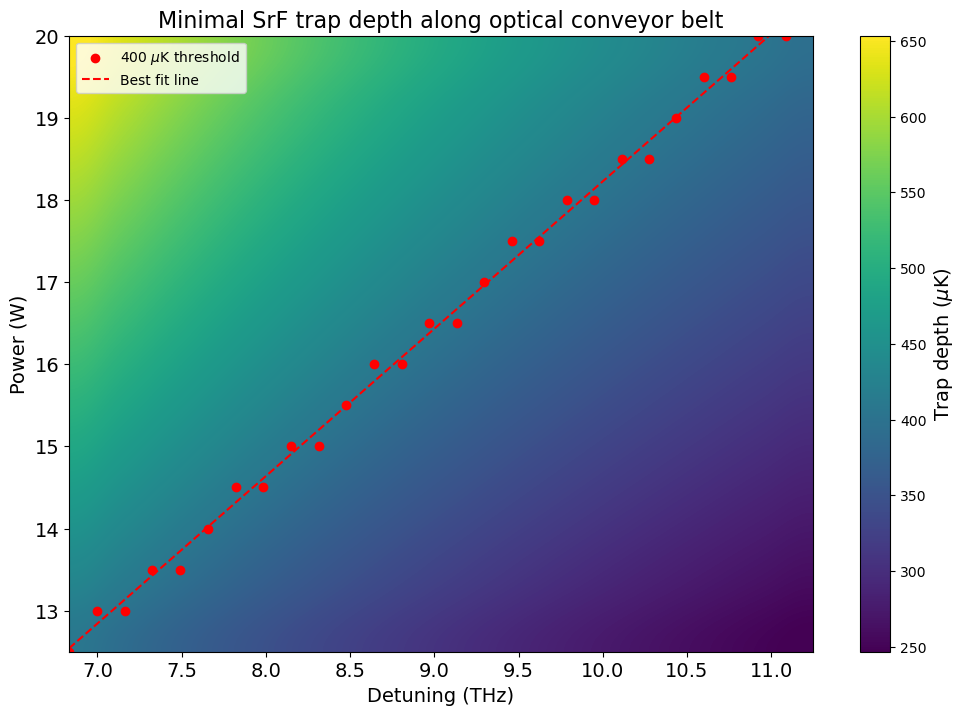

Best fit (quadratic): P (W) = 0.92 (1/THz^2) * Δ^2 (THz^2) + -11.93 (1/THz) * Δ (THz) + 50.52 (W)


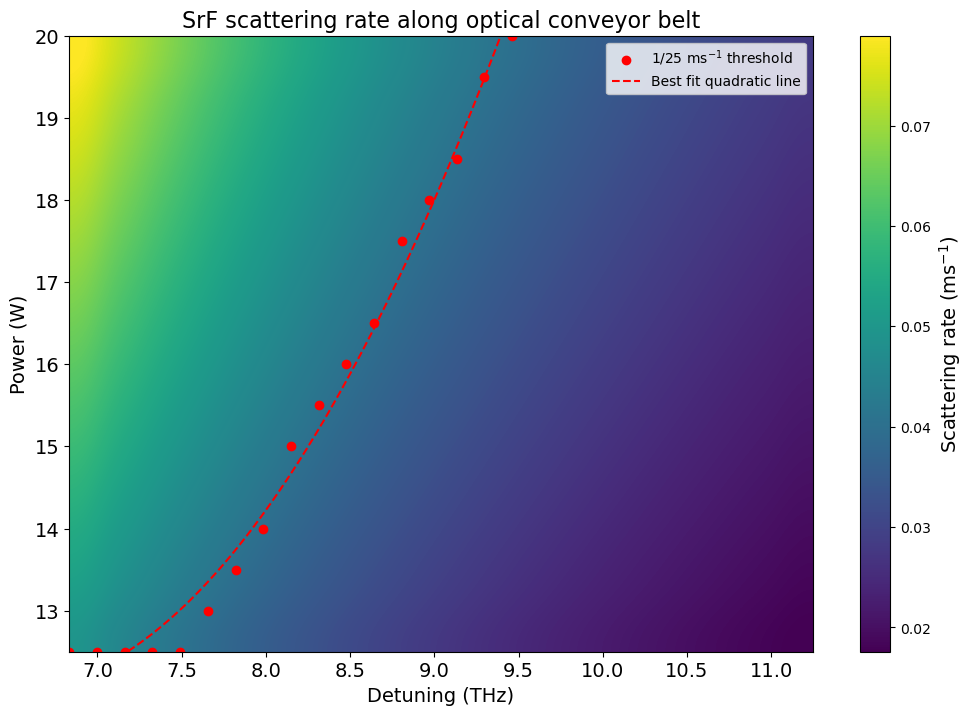

In [305]:
#plot result from above


#in best trap depths, for each detuning, extract the power that first exceeds a minimal trap depth of 400 uK
threshold = 400 #in uK
mask = best_trap_depths > threshold

# Use argmax to find the first occurrence in each row
# argmax will return the index of the first True value in each row
indices = np.argmax(mask, axis=1)

# Replace indices where no value exceeds the threshold with np.nan
powers = [Ps[idx] if mask[i, idx] else np.nan for i, idx in enumerate(indices)]

# Find the index up to where powers are not nan
valid_indices = [i for i, power in enumerate(powers) if not np.isnan(power)]

# Extract valid points for plotting
valid_detunings = [detunings[i] for i in valid_indices]
valid_powers = [Ps[indices[i]] for i in valid_indices]

# Fit a line to the valid points
fit = np.polyfit(valid_detunings, valid_powers, 1)
fit_fn = np.poly1d(fit)

# Define the range for the best fit line
fit_x = np.linspace(min(valid_detunings), max(valid_detunings), 100)



plt.figure(figsize=(12, 8))
plt.imshow(np.transpose(best_trap_depths), extent=[detunings[0]/1e12, detunings[-1]/1e12, Ps[0], Ps[-1]], origin='lower', interpolation='spline36', aspect='auto')
plt.colorbar().set_label('Trap depth ($\mu$K)', fontsize=14)
plt.xlabel('Detuning (THz)', fontsize=14)
plt.ylabel('Power (W)', fontsize=14)
plt.title('Minimal SrF trap depth along optical conveyor belt', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


# Overlay the powers
for i in valid_indices:
    plt.scatter(detunings[i]/1e12, Ps[indices[i]], color='red', label='400 $\mu$K threshold' if i == valid_indices[0] else "")


start_power_scan = 12.5 # in W
end_power_scan = 20.5 # in W
power_scan_increment = 0.5 # in W
# Plot the best fit line
plt.plot(fit_x/1e12, fit_fn(fit_x), color='red', linestyle='--', label='Best fit line')
plt.ylim(start_power_scan, end_power_scan - power_scan_increment)
plt.legend()

# Return the parameters of the best fit line
slope, intercept = fit
print(f"Best fit (linear): P (W) = {slope*1e12:.2f} (1/THz) * \u0394 (THz) + {intercept:.2f} (W)")

plt.show()


#in scattering_rates, for each detuning, extract the power that first exceeds the threshold scattering rate of 1/25 ms^-1
threshold2 = 1/25 #in ms^-1
mask2 = scattering_rates/1e3 > threshold2 #since scattering_rates is in s^-1

# Use argmax to find the first occurrence in each row
# argmax will return the index of the first True value in each row
indices2 = np.argmax(mask2, axis=1)

# Replace indices where no value exceeds the threshold with np.nan
powers2 = [Ps[idx] if mask2[i, idx] else np.nan for i, idx in enumerate(indices2)]

# Find the index up to where powers are not nan
valid_indices2 = [i for i, power2 in enumerate(powers2) if not np.isnan(power2)]

# Extract valid points for plotting
valid_detunings2 = [detunings[i] for i in valid_indices2]
valid_powers2 = [Ps[indices2[i]] for i in valid_indices2]

# Fit a quadratic line to the valid points
fit2 = np.polyfit(valid_detunings2, valid_powers2, 2)
fit_fn2 = np.poly1d(fit2)

# Define the range for the best fit line
fit_x2 = np.linspace(min(valid_detunings2), max(valid_detunings2), 100)



plt.figure(figsize=(12, 8))
plt.imshow(np.transpose(scattering_rates/1e3), extent=[detunings[0]/1e12, detunings[-1]/1e12, Ps[0], Ps[-1]], origin='lower', interpolation='spline36', aspect='auto')
plt.colorbar().set_label('Scattering rate (ms$^{-1}$)', fontsize=14)
plt.xlabel('Detuning (THz)', fontsize=14)
plt.ylabel('Power (W)', fontsize=14)
plt.title('SrF scattering rate along optical conveyor belt', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


# Overlay the powers
for i in valid_indices2:
    plt.scatter(detunings[i]/1e12, Ps[indices2[i]], color='red', label='1/25 ms$^{-1}$ threshold' if i == valid_indices2[0] else "")

# Plot the best fit quadratic line
plt.plot(fit_x2/1e12, fit_fn2(fit_x2), color='red', linestyle='--', label='Best fit quadratic line')
plt.ylim(start_power_scan, end_power_scan - power_scan_increment)
plt.legend()

# Return the parameters of the best fit quadratic line
a, b, d = fit2
print(f"Best fit (quadratic): P (W) = {a*1e24:.2f} (1/THz^2) * \u0394^2 (THz^2) + {b*1e12:.2f} (1/THz) * \u0394 (THz) + {d:.2f} (W)")
 
plt.show()

# Plot Corresponding Heating Rate (Rayleigh Scattering?)

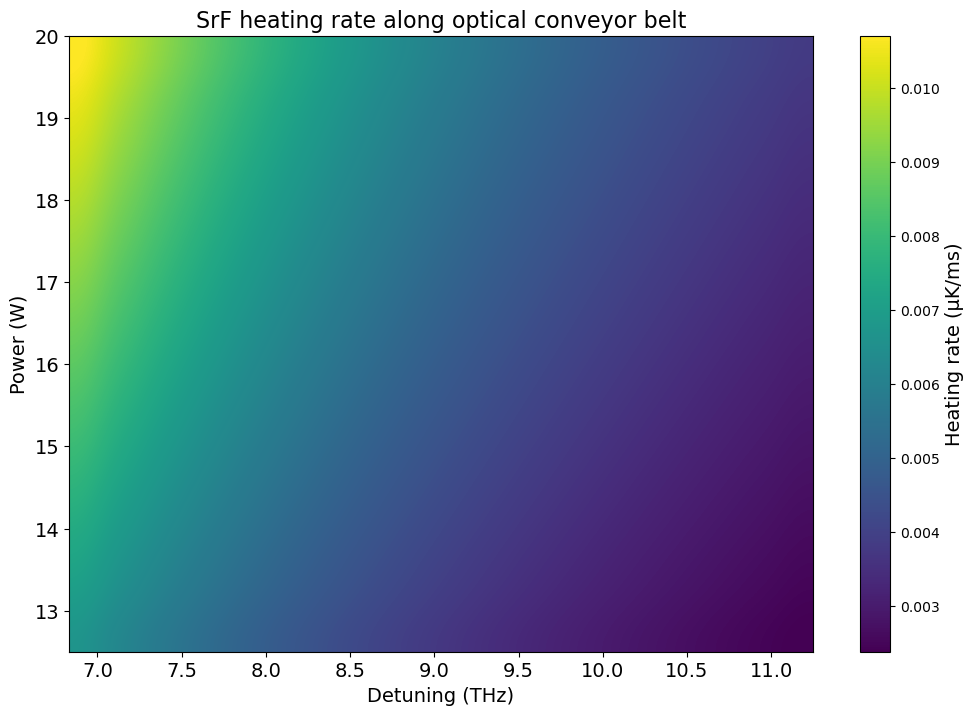

In [306]:
#also add in the heating rate
resonance_wavelen = c / resonance_freq
recoil_temp = hbar**2 * (2*np.pi/resonance_wavelen)**2 / (m_SrF * k)

heating_rates = scattering_rates * recoil_temp/3

plt.figure(figsize=(12, 8))
plt.imshow(np.transpose(heating_rates*1e3), extent=[detunings[0]/1e12, detunings[-1]/1e12, Ps[0], Ps[-1]], origin='lower', interpolation='spline36', aspect='auto')
plt.colorbar().set_label('Heating rate (µK/ms)', fontsize=14)
plt.xlabel('Detuning (THz)', fontsize=14)
plt.ylabel('Power (W)', fontsize=14)
plt.title('SrF heating rate along optical conveyor belt', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

# Compute first (P, $\Delta$) beyond which scheme meets our target (assuming maximal rotational Raman scattering)

First detuning where scattering rate is below 0.04 ms^-1: 8.21 THz
Power required to maintain 400 µK trap depth at this detuning: 15.02 W
Corresponding wavelength: 675.60 nm


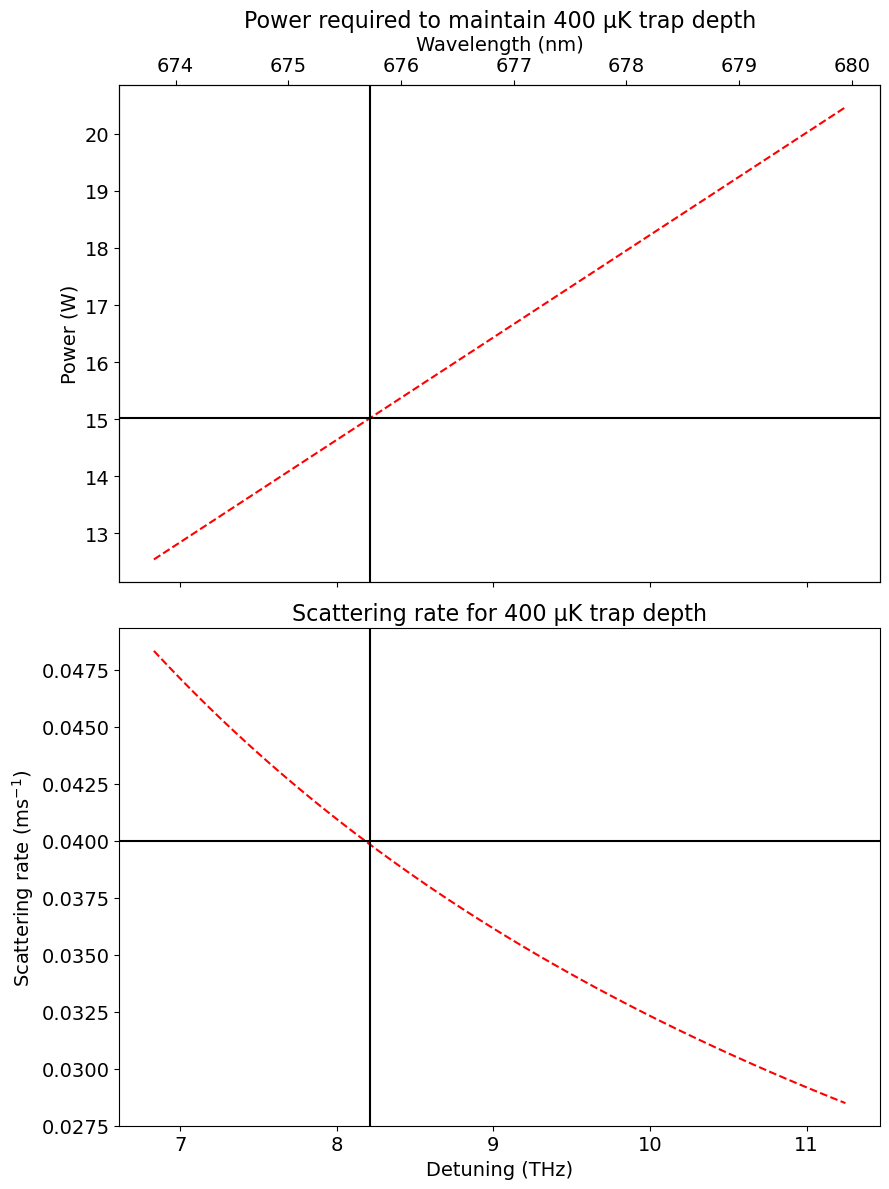

In [307]:
# Define the range for the best fit line
fit_x3 = np.linspace(detunings[0], detunings[-1], 100)

# Function to convert frequency (Hz) to wavelength (nm)
def freq_to_wavelength(frequency):
    return c / frequency * 1e9  # Convert to nm

# Convert detunings to wavelengths
wavelengths = freq_to_wavelength(resonance_freq - detunings)


fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(9, 12), sharex=True)

# First plot: Power vs Detuning
ax1.plot(fit_x3 / 1e12, fit_fn(fit_x3), color='red', linestyle='--')
"""
for i in valid_indices:
    ax1.scatter(detunings[i] / 1e12, Ps[indices[i]], color='red', label='400 $\mu$K threshold' if i == valid_indices[0] else "")
"""
ax1.set_ylabel('Power (W)', fontsize=14)
ax1.set_title('Power required to maintain 400 µK trap depth', fontsize=16)
ax1.tick_params(axis='both', labelsize=14)

# Second plot: Scattering rate vs Detuning
scattering_rate_fixed_depth = gamma_SrF * (400 * k * 1e-6) / (hbar * 2 * np.pi * fit_x3) * ((resonance_freq - fit_x3) / resonance_freq) ** 3
ax3.plot(fit_x3 / 1e12, scattering_rate_fixed_depth / 1e3, color='red', linestyle='--')
ax3.set_xlabel('Detuning (THz)', fontsize=14)
ax3.set_ylabel('Scattering rate (ms$^{-1}$)', fontsize=14)
ax3.set_title('Scattering rate for 400 µK trap depth', fontsize=16)
ax3.tick_params(axis='both', labelsize=14)

# Create a secondary x-axis for wavelength
ax2 = ax1.twiny()
ax2.set_xlim(wavelengths[0], wavelengths[-1])
ax2.set_xlabel('Wavelength (nm)', fontsize=14)
ax2.tick_params(axis='x', labelsize=14)

# Find the first value of detuning where scattering rate is below 0.04
below_threshold_indices = np.where(scattering_rate_fixed_depth / 1e3 < 0.04)[0]
first_below_threshold_detuning = fit_x3[below_threshold_indices[0]] if below_threshold_indices.size > 0 else None
print(f"First detuning where scattering rate is below 0.04 ms^-1: {first_below_threshold_detuning / 1e12:.2f} THz")

#find the corresponding power for the first detuning where scattering rate is below 0.04. power will be above the threshold
power_above_threshold = fit_fn(first_below_threshold_detuning)
print(f"Power required to maintain 400 µK trap depth at this detuning: {power_above_threshold:.2f} W")

#print the corresponding wavelength to that detuning
wavelength_at_threshold = freq_to_wavelength(resonance_freq - first_below_threshold_detuning)
print(f"Corresponding wavelength: {wavelength_at_threshold:.2f} nm")

# Add vertical and horizontal lines
if first_below_threshold_detuning is not None:
    ax1.axvline(x=first_below_threshold_detuning / 1e12, color='black', linestyle='-')
    ax1.axhline(y=power_above_threshold, color='black', linestyle='-')
    ax3.axvline(x=first_below_threshold_detuning / 1e12, color='black', linestyle='-')
    ax3.axhline(y=0.04, color='black', linestyle='-')

plt.tight_layout()
plt.show()